In [1]:
from datetime import timedelta

# Config
STATE = 42 # Used for consistency during development, should be removed when performing actual anomaly detection.
SERVICE = 'ServiceA'
LAMBDA = 'LambdaB'

USE_DURATION = True
METRIC = 'Duration' if USE_DURATION else 'ConcurrentExecutions' # Should be 'Duration' or 'ConcurrentExecutions'
METRIC_SLICE = None
# METRIC_SLICE = [5000, 8000] # Optional array for using only a slice of the whole metric e.g. [5000, 8000] will use df[5000:8000] later on

N_CLUSTERS = 500 # (Int, Optional) Number of clusters for K-Means.
SEGMENT_LEN = 32 # (Int, required)
SLIDE_LEN = 2 # (Int, required)
GRAPH_GAP_TRESHOLD = timedelta(hours=2) # (Timedelta, required) Timestamp difference limit between two adjacent data points. No line is drawn between the points for greater values.
ANOMALY_NEIGHBOR_LIMIT = 1 # (Int, optional) Minimum number of anomalies in a row. Anomalies under this number are removed. 
POST_RELEASE_TRESHOLD = timedelta(days=1) # (Timedelta, optional) If defined, all anomalies after a release date within the treshold will be summed up and marked in the final graph.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import util
import json
from sklearn.cluster import KMeans

matplotlib.interactive('True')

# Metric conversion from exported CloudWatch JSON to pandas DataFrames
metrics = util.json_to_pandas(f'../ExportedMetrics/{SERVICE}/{LAMBDA}.json')
for metric in metrics:
    print(f'{metric.upper()}:\n',metrics[metric], '\n\n')
    metrics[metric].to_csv('./output/csv/ServiceALambdaB' + metric + '.csv')

DURATION:
                      Timestamps      Values
0     2020-10-17 11:45:00+00:00   55.396667
1     2020-10-17 11:50:00+00:00   73.666000
2     2020-10-17 11:55:00+00:00   51.154615
3     2020-10-17 12:00:00+00:00   67.356667
4     2020-10-17 12:05:00+00:00   91.800000
...                         ...         ...
17912 2020-12-19 10:07:00+00:00   79.106667
17913 2020-12-19 10:12:00+00:00   52.544444
17914 2020-12-19 10:17:00+00:00  107.693333
17915 2020-12-19 10:22:00+00:00   55.663333
17916 2020-12-19 10:27:00+00:00   86.290000

[17917 rows x 2 columns] 


CONCURRENTEXECUTIONS:
                      Timestamps    Values
0     2020-10-17 11:45:00+00:00  1.333333
1     2020-10-17 11:50:00+00:00  1.200000
2     2020-10-17 11:55:00+00:00  1.307692
3     2020-10-17 12:00:00+00:00  1.333333
4     2020-10-17 12:05:00+00:00  1.333333
...                         ...       ...
17912 2020-12-19 10:07:00+00:00  1.000000
17913 2020-12-19 10:12:00+00:00  1.222222
17914 2020-12-19 10:17:00+00:00

In [3]:
releases = util.load_releases('../ExportedMetrics/releases.json')
releases.head(10)

,ServiceNames,Timestamps
0,ServiceA,2020-10-15 13:09:02.003799915+00:00
1,ServiceHIK,2020-10-15 14:18:49.004899979+00:00
2,ServiceB,2020-10-15 14:21:56.005199909+00:00
3,ServiceB,2020-10-19 08:30:09.000400066+00:00
4,ServiceHIK,2020-10-21 13:49:47.005199909+00:00
5,ServiceB,2020-10-22 12:20:14.000600100+00:00
6,ServiceCD,2020-10-23 14:04:43.000400066+00:00
7,ServiceB,2020-10-28 09:16:09.000900030+00:00
8,ServiceB,2020-10-28 11:33:24.003599882+00:00
9,ServiceA,2020-10-29 09:56:09.004199982+00:00


In [4]:
# Some microservices are grouped together during release
release_service_map = {
    'ServiceA': 'ServiceA',
    'ServiceB': 'ServiceB',
    'ServiceC': 'ServiceCD',
    'ServiceD': 'ServiceCD',
    'ServiceE': 'ServiceEF',
    'ServiceF': 'ServiceEF',
    'ServiceG': None,
    'ServiceH': 'ServiceHIK',
    'ServiceI': 'ServiceHIK',
    'ServiceJ': 'ServiceJ',
    'ServiceK': 'ServiceHIK'
}

service_releases = releases.loc[releases['ServiceNames'] == release_service_map[SERVICE]] if release_service_map[SERVICE] != None else None

In [5]:
try:
    df = metrics[METRIC]
except:
    import winsound
    winsound.Beep(700, 200)
    winsound.Beep(500, 200)
    winsound.Beep(250, 600)

df_test = df.copy()

### Adding feature `Release_Point` for rows right after a microservice deployment

In [6]:
df_test = util.calculate_release_point_feature(df_test, service_releases)

Earliest in-scope release date:  2020-10-17 11:50:00+00:00
Latest in-scope release date:  2020-12-19 10:27:00+00:00
Dropped 1 out of scope release date(s)


### Adding feature `Post_Release` for data points within `POST_RELEASE_TRESHOLD` after a release point.

In [7]:
df_test = util.calculate_post_release_feature(df_test, POST_RELEASE_TRESHOLD)
df_test.loc[df_test.Post_Release == 1]

,Timestamps,Values,Release_Point,Post_Release
3435,2020-10-29 10:00:00+00:00,63.816667,1,1
3436,2020-10-29 10:05:00+00:00,61.706667,0,1
3437,2020-10-29 10:10:00+00:00,54.724000,0,1
3438,2020-10-29 10:15:00+00:00,78.813077,0,1
3439,2020-10-29 10:20:00+00:00,54.713333,0,1
...,...,...,...,...
17670,2020-12-18 13:57:00+00:00,87.880000,0,1
17671,2020-12-18 14:02:00+00:00,105.306667,0,1
17672,2020-12-18 14:07:00+00:00,60.203333,0,1
17673,2020-12-18 14:12:00+00:00,62.358333,0,1


In [8]:
df_test.loc[df_test['Post_Release'] == 1]

,Timestamps,Values,Release_Point,Post_Release
3435,2020-10-29 10:00:00+00:00,63.816667,1,1
3436,2020-10-29 10:05:00+00:00,61.706667,0,1
3437,2020-10-29 10:10:00+00:00,54.724000,0,1
3438,2020-10-29 10:15:00+00:00,78.813077,0,1
3439,2020-10-29 10:20:00+00:00,54.713333,0,1
...,...,...,...,...
17670,2020-12-18 13:57:00+00:00,87.880000,0,1
17671,2020-12-18 14:02:00+00:00,105.306667,0,1
17672,2020-12-18 14:07:00+00:00,60.203333,0,1
17673,2020-12-18 14:12:00+00:00,62.358333,0,1


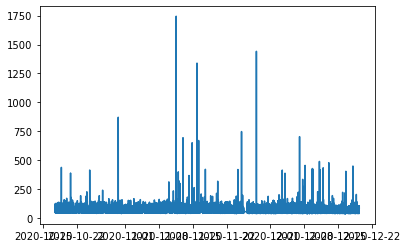

In [9]:
plt.plot(df_test.Timestamps, df_test.Values)
plt.show()

### K-Means

Splitting the data frame into a series of overlapping windows:

In [10]:
df_test, segments = util.window_df(df_test, segment_len=SEGMENT_LEN, slide_len=SLIDE_LEN)
print(df_test.loc[df_test['Post_Release'] == 1])

Dropped 29 row(s) from the beginning
                     Timestamps      Values  Release_Point  Post_Release
3435  2020-10-29 10:00:00+00:00   63.816667              1             1
3436  2020-10-29 10:05:00+00:00   61.706667              0             1
3437  2020-10-29 10:10:00+00:00   54.724000              0             1
3438  2020-10-29 10:15:00+00:00   78.813077              0             1
3439  2020-10-29 10:20:00+00:00   54.713333              0             1
...                         ...         ...            ...           ...
17670 2020-12-18 13:57:00+00:00   87.880000              0             1
17671 2020-12-18 14:02:00+00:00  105.306667              0             1
17672 2020-12-18 14:07:00+00:00   60.203333              0             1
17673 2020-12-18 14:12:00+00:00   62.358333              0             1
17674 2020-12-18 14:17:00+00:00   51.290000              0             1

[4325 rows x 4 columns]


Normalized segments: By multiplying each window by a bell curve we get a windows that always start and end with 0. This is useful for reconstruction later.

In [11]:
windowed_segments = util.normalize_segments(segments, feature='Values', segment_len=SEGMENT_LEN)

* todo

In [12]:
clusterer = KMeans(n_clusters=500)
clusterer.fit(windowed_segments[0:int(len(windowed_segments)/2)])

KMeans(n_clusters=500)

In [13]:
print(type(df_test))

<class 'pandas.core.frame.DataFrame'>


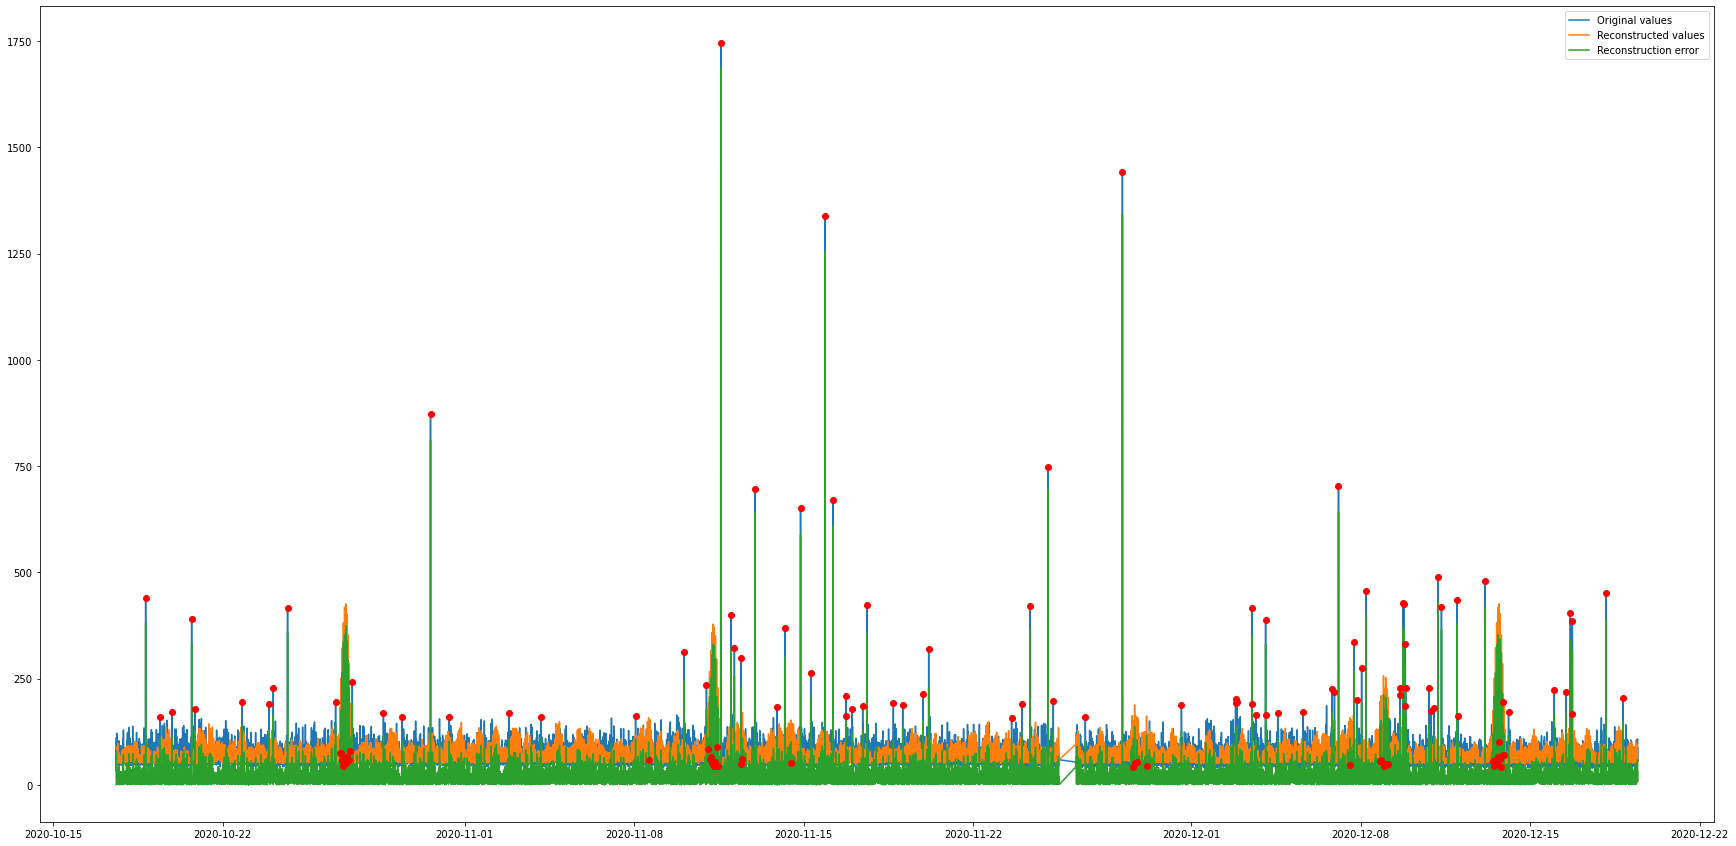

In [14]:
# reconstruction = np.zeros(len(df))
# # reconstruction = np.full(len(df), df.Values.mean())
# slide_len = segment_len/2

# df_test = df.copy()
# df_test['Reconstructed_Values'] = 0

# for segment_n, segment in enumerate(test_segments[0:len(test_segments)]):
#     segment = segment.copy()
#     # if (len(segment) != 32):
#     #     print(segment_n, len(segment))
#     segment.Values *= window
#     # print(clusterer.predict([segment.Values])[0])
#     nearest_centroid_idx = clusterer.predict([segment.Values])[0]
#     centroids = clusterer.cluster_centers_
#     nearest_centroid = np.copy(centroids[nearest_centroid_idx])

#     pos = int(segment_n * slide_len)

#     # if (segment_n > 500):
#     #     print(pos, segment_len, len(nearest_centroid))
#     #     print(len(reconstruction[pos:pos+segment_len]))
#     reconstruction[pos:pos+segment_len] += nearest_centroid[0:len(reconstruction[pos:pos+segment_len])]

# df_test['Reconstructed_Values'] = reconstruction
# df_test['Reconstruction_Error'] = df_test['Reconstructed_Values'] - df.Values
# df_test['Anomalies'] = (abs(df_test['Reconstruction_Error']) > 100).astype(int)

def reconstruct(df, feature, clusterer, segments, segment_len, slide_len):
    window_rads = np.linspace(0, np.pi, SEGMENT_LEN)
    window = np.sin(window_rads) ** 2

    test_segments = util.sliding_chunker(df, segment_len, slide_len)
    slide_len = segment_len/2

    reconstruction = np.zeros(len(df))
    df['Reconstructed_Values'] = 0

    for i, segment in enumerate(test_segments):
        segment = segment.copy()
        segment[feature] *= window
        nearest_centroid_idx = clusterer.predict([segment[feature]])[0]
        centroids = clusterer.cluster_centers_
        nearest_centroid = np.copy(centroids[nearest_centroid_idx])

        pos = int(i * slide_len)
        reconstruction[pos:pos+segment_len] += nearest_centroid[0:len(reconstruction[pos:pos+segment_len])]

    df_test['Reconstructed_Values'] = reconstruction
    df_test['Reconstruction_Error'] = abs(df_test['Reconstructed_Values'] - df.Values)
    df_test['Anomalies'] = (df_test['Reconstruction_Error'] > 100).astype(int)

    return df

df_test = reconstruct(df_test, 'Values', clusterer, segments, SEGMENT_LEN, SLIDE_LEN)
anomalies = df_test.loc[df_test.Anomalies == 1]

fig = plt.figure(figsize=(30,15))
plt.plot(df_test.Timestamps, df_test.Values, label='Original values')
plt.plot(df_test.Timestamps, df_test.Reconstructed_Values, label='Reconstructed values')
plt.plot(df_test.Timestamps, df_test['Reconstruction_Error'], label='Reconstruction error')
plt.plot(anomalies.Timestamps, anomalies.Values, 'o', color='red')
plt.legend()
plt.show()

### Cleaning up point anomalies with optional parameters

In [15]:
# Removing anomalies not part of a group at least ANOMALY_NEIGHBOR_LIMIT long
try:
    df_test = util.limit_anomalies(df_test, 'Anomalies', -1, 1, ANOMALY_NEIGHBOR_LIMIT)
except NameError:
    print('Optional ANOMALY_NEIGHBOR_LIMIT undefined, continuing.')

Anomalies dropped for feature "Anomalies": 0


In [16]:
anomaly_counts = df_test.Anomalies.value_counts()[1] if 1 in df_test.Anomalies.value_counts() else 0
print(f'Anomalous data points: {anomaly_counts} / {len(df_test["Anomalies"])}')

Anomalous data points: 134 / 17888


In [17]:
df_test['Gap'] = (df.Timestamps.diff() >= GRAPH_GAP_TRESHOLD).astype(int)
print(df_test.loc[df_test['Gap'] == 1])

                     Timestamps  Values  Release_Point  Post_Release  \
11240 2020-11-26 06:10:00+00:00   52.99              0             0   

       Reconstructed_Values  Reconstruction_Error  Anomalies  Gap  
11240             96.294671             43.304671          0    1  


17917
17888
17888


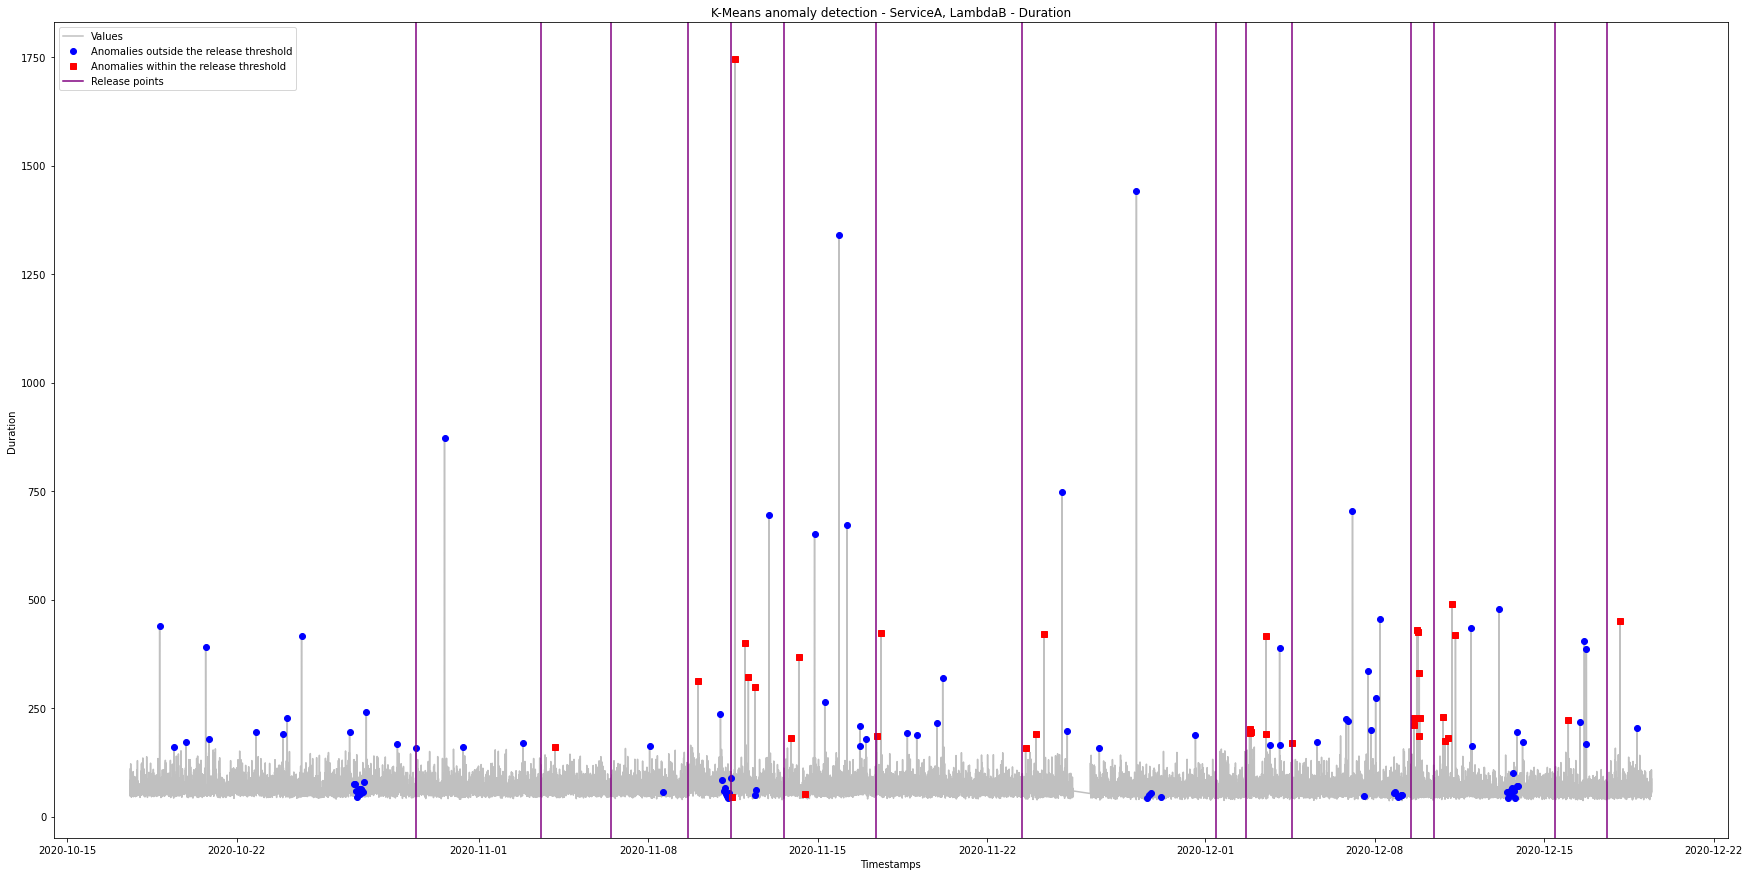

Post-release anomalies: 35 of 99 total values anomalies


In [18]:
import numpy.ma as ma

values_inside_release_treshold = df_test.loc[df_test.Post_Release == 1]
values_outside_release_treshold = df_test.loc[df_test.Post_Release == 0]
release_points = df_test.loc[df_test.Release_Point == 1]

# Anomalies not soon after a release
anomalies = df_test.loc[(df_test.Anomalies == 1) & (df_test.Post_Release == 0)]

# Anomalies soon after a release
post_release_anomalies = df_test.loc[(df_test.Anomalies == 1) & (df_test.Post_Release == 1)]

from matplotlib.pyplot import figure
plt.figure(figsize=(30,15))
plt.xlabel("Timestamps")
plt.ylabel('Duration' if METRIC == 'Duration' else 'Concurrent Executions')


# Not close to release
mc = ma.array(df.Values.values)

print(len(df.Values))
print(len(df_test.Post_Release == 1))
print(len(df_test.Gap))

# TODO: Fix
# mc[(df_test.Post_Release == 1) | (df_test.Gap)] = ma.masked
# plt.plot(df_test.Timestamps.values, mc, color='silver')

# # Close to release
# mc = ma.array(df.Values.values)
# mc[(df_test.Post_Release == 0) | (df_test.Gap)] = ma.masked
# plt.plot(df_test.Timestamps.values, mc, color='dimgrey')

plt.plot(df_test.Timestamps, df_test.Values, color='silver')
plt.plot(anomalies.Timestamps, anomalies.Values, 'o', color='blue')
plt.plot(post_release_anomalies.Timestamps, post_release_anomalies.Values, 's', color='red')


# Release date lines
for release in release_points.Timestamps:
    plt.axvline(release, color='purple')

plt.title(f'K-Means anomaly detection - {SERVICE}, {LAMBDA} - {METRIC}')
plt.legend([
    # f'Values within release treshold ({GRAPH_GAP_TRESHOLD})',
    # f'Values outside release treshold ({GRAPH_GAP_TRESHOLD})',
    'Values',
    'Anomalies outside the release threshold',
    'Anomalies within the release threshold',
    'Release points'
], loc=2)

# plt.ylim(0, 2000)

# Output .png & .pdf files
import os

savedir = f'{os.getcwd()}\\output\\k-means\\{SERVICE}\\{LAMBDA}'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plt.savefig(f'{savedir}\\{METRIC}.pdf', transparent=True, bbox_tight="inches")
plt.savefig(f'{savedir}\\{METRIC}.png')

plt.show()

print(f'Post-release anomalies: {len(post_release_anomalies)} of {len(anomalies)} total values anomalies')